In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import numpy as np
import xarray as xr
from scipy import stats
import cmaps
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker
import scipy.io as scio
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore") 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"


In [8]:
### 
file_hgt = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/HGT/ERA5-hgt.nc")
hgt_data = file_hgt['z'].loc[file_hgt.time.dt.month.isin((7)) & file_hgt.time.dt.year.isin(np.arange(1979,2023,1)),1] 
hgt_2022 = hgt_data[-1]- hgt_data.mean('time')
file_uwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/UWND/ERA5-uwnd.nc")
uwnd_data = file_uwnd['u'].loc[file_uwnd.time.dt.month.isin((7)) & file_uwnd.time.dt.year.isin(np.arange(1979,2023,1)),1]
uwnd_2022 = np.array(uwnd_data[-1]- uwnd_data.mean('time'))
file_vwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/VWND/ERA5-vwnd.nc")
vwnd_data = file_vwnd['v'].loc[file_vwnd.time.dt.month.isin((7)) & file_vwnd.time.dt.year.isin(np.arange(1979,2023,1)),1]
vwnd_2022 = np.array(vwnd_data[-1]- vwnd_data.mean('time'))
lon = file_hgt['longitude'].values
lat = file_hgt['latitude'].values
lev = file_hgt['level']
print(lev)


<xarray.DataArray 'level' (level: 14)>
array([  10,   20,   50,  100,  150,  200,  250,  300,  400,  500,  700,  850,
        925, 1000], dtype=int32)
Coordinates:
  * level    (level) int32 10 20 50 100 150 200 250 300 400 500 700 850 925 1000
Attributes:
    units:      millibars
    long_name:  pressure_level


### the codes for TN WAF are from https://cloud.tencent.com/developer/article/1829812 (or 微信公众号 好奇心log)

In [9]:
a=6.37e6 #地球半径
omega=7.292e-5 #地球自转角速度
dlon=np.gradient(lon)*np.pi/180.0
dlat=np.gradient(lat)*np.pi/180.0
f=np.array(list(map(lambda x : 2*omega*np.sin(x*np.pi/180.0),lat))) #科氏力参数: f=2*omgega*sin(lat)
cos_lat=np.array(list(map(lambda x : np.cos(x*np.pi/180.0),lat))) #cos(lat)
u_c=np.average(uwnd_data,axis=0)
v_c=np.average(vwnd_data,axis=0)
phi_c=np.average(hgt_data,axis=0)
phi_p=np.array(hgt_data[-1]-phi_c).squeeze()
psi_850=(phi_p[11,:,:].T/f).T #计算扰动流函数
psi_p=(phi_p[5,:,:].T/f).T #计算扰动流函数
dpsi_dlon=np.gradient(psi_p,dlon[1])[1]
dpsi_dlat=np.gradient(psi_p,dlat[1])[0]
d2psi_dlon2=np.gradient(dpsi_dlon,dlon[1])[1]
d2psi_dlat2=np.gradient(dpsi_dlat,dlat[1])[0]
d2psi_dlondlat=np.gradient(dpsi_dlat,dlon[1])[1]
termxu=dpsi_dlon*dpsi_dlon-psi_p*d2psi_dlon2
termxv=dpsi_dlon*dpsi_dlat-psi_p*d2psi_dlondlat
termyv=dpsi_dlat*dpsi_dlat-psi_p*d2psi_dlat2
p_lev=200
p=p_lev/1000.0
magU=np.sqrt(u_c**2+v_c**2)
coeff=((p*cos_lat)/(2*magU[5,:,:].T)).T
#x方向分量
px=(coeff.T/(a*a*cos_lat)).T * (((u_c[5,:,:].T)/cos_lat).T*termxu+v_c[5,:,:]*termxv)
#x方向分量
py=(coeff.T/(a*a)).T * (((u_c[5].T)/cos_lat).T*termxv+v_c[5]*termyv)
px[70:,:]=np.nan
py[70:,:]=np.nan
px[(px**2+py**2)**0.5<3]=np.nan
py[(px**2+py**2)**0.5<3]=np.nan


#### short-wave and cloud dataset are from CERES

In [10]:
file_rad = xr.open_dataset("/public/home/songqh/my_data/CERES/CERES_EBAF_Ed4.2_sfc_Subset_200003-202306.nc")
file_cld = xr.open_dataset("/public/home/songqh/my_data/CERES/CERES_EBAF_Ed4.2_cloud_Subset_200003-202306.nc")
sw_data = file_rad['sfc_net_sw_all_mon'].loc[file_rad.time.dt.year.isin(np.arange(2000,2023,1)) & file_rad.time.dt.month.isin(7)]
cld_data = file_cld['cldarea_total_daynight_mon'].loc[file_cld.time.dt.year.isin(np.arange(2000,2023,1)) & file_cld.time.dt.month.isin(7)]
ssw_index = np.nanmean(sw_data.loc[:,50:60,140:175],axis=(1,2))
cld_index = np.nanmean(cld_data.loc[:,50:60,140:175],axis=(1,2))
ssw_index = (ssw_index - np.mean(ssw_index)) / np.std(ssw_index)
cld_index = (cld_index - np.mean(cld_index)) / np.std(cld_index)
lon1 = file_rad['lon'].values
lat1 = file_rad['lat'].values
sw_2022 = sw_data[-1] - sw_data.mean('time')
cld_2022 = cld_data[-1] - cld_data.mean('time')


-0.8774526378151344 3.860284553524923e-08


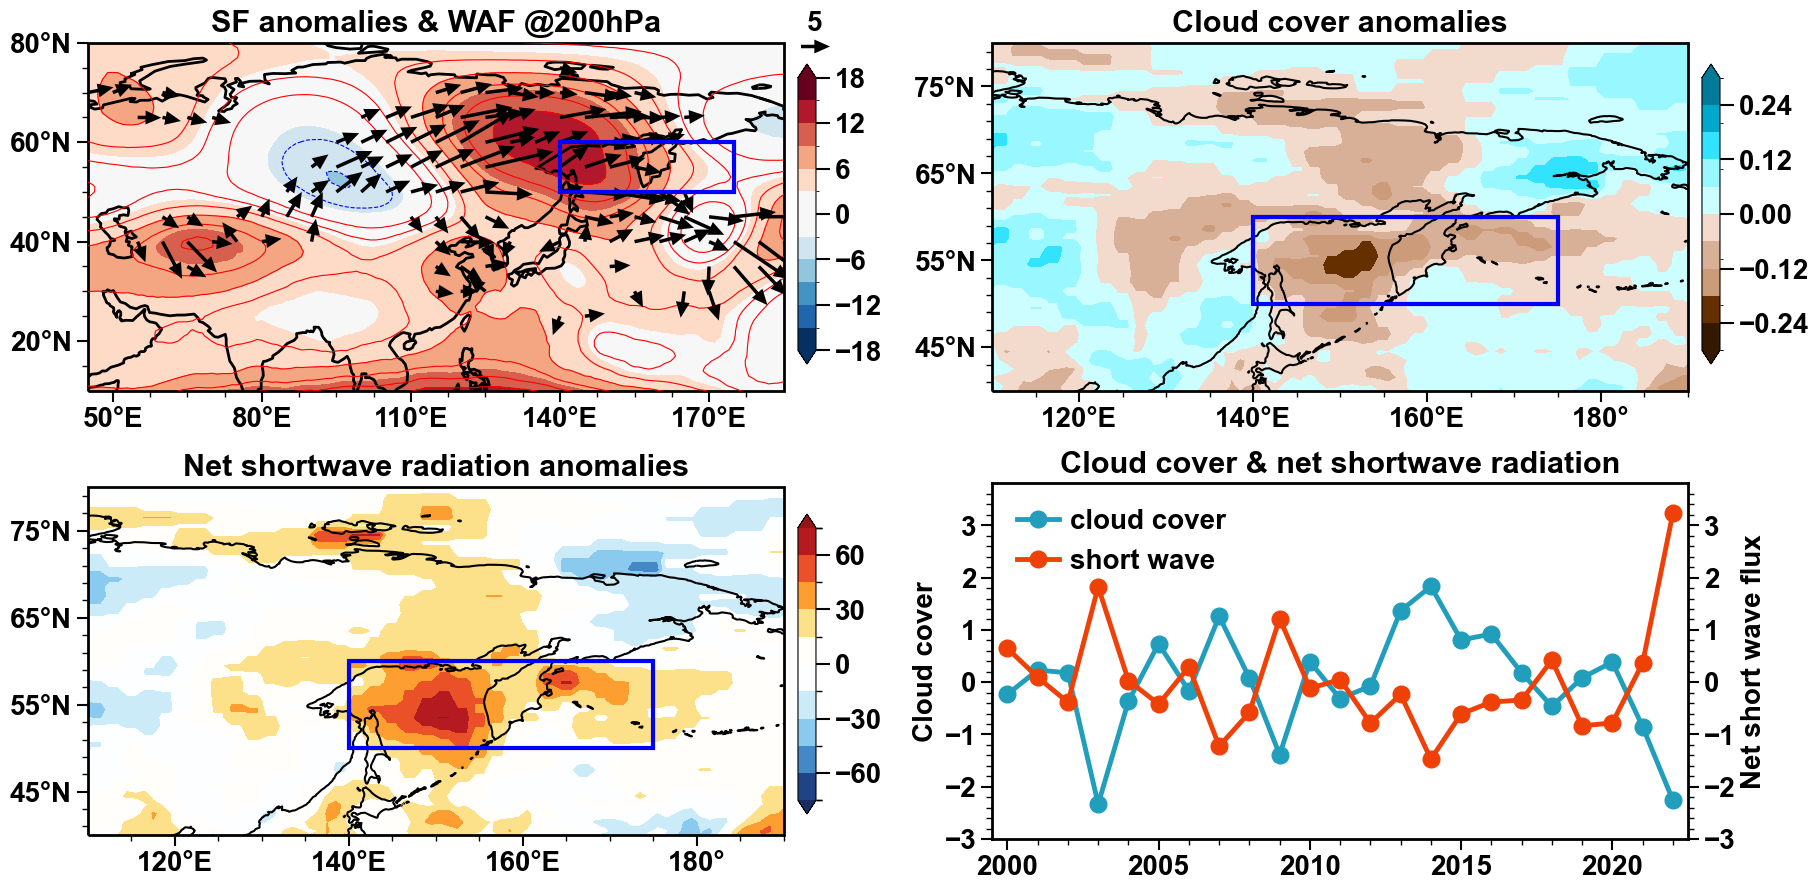

In [15]:
proj = ccrs.PlateCarree(central_longitude=145)
fig = plt.figure(figsize=(20,10))
# subplot-1
ax1 = fig.add_subplot(221,projection=proj)
leftlon, rightlon, lowerlat, upperlat = (45,185,10,80)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND.with_scale('110m'),color='lightgray') 
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'),lw=2) 
ax1.set_xticks(np.arange(50,200,30), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(20,upperlat+20,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(direction='out', length=4, width=1, labelsize=20,axis='both', which='minor')
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax1.minorticks_on()
ax1.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax1.set_title('SF anomalies & WAF @200hPa',weight='bold',fontsize=22,loc='center',pad=8)
q = ax1.quiver(lon[::5],lat[::5],px[::5,::5],py[::5,::5],transform=ccrs.PlateCarree(),scale=120,color='k',
               headwidth=4,width=0.005,headlength=4.5,zorder=1000)
qk = ax1.quiverkey(q, 1.045, 0.99, U=5, label='5',zorder=300000,labelpos='N', coordinates='axes',color='k',fontproperties={'size': 20},labelcolor='k')
ax1.contour(lon,lat,(psi_p)/1e6,levels=np.arange(0,20,2),colors='r',zorder=10,linewidths=0.8,transform=ccrs.PlateCarree())
ax1.contour(lon,lat,(psi_p)/1e6,levels=np.arange(-18,-2,2),colors='b',linestyle='--',linewidths=0.8,zorder=10,transform=ccrs.PlateCarree())
cf1 = ax1.contourf(lon,lat,(psi_p)/1e6,levels=np.arange(-18,21,3),zorder=0, extend = 'both',
                   transform=ccrs.PlateCarree(), cmap=cmaps.CBR_coldhot)
ax1.add_patch(patches.Rectangle([-5,50],35,10,linewidth=3,edgecolor='blue',facecolor='none',zorder=1000000))

pos = fig.add_axes([0.455,0.575,0.009,0.3])
cb = fig.colorbar(cf1, orientation='vertical', cax=pos)
cb.ax.tick_params(which='major',labelsize=20, length=10, width=1.5)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(3))

# subplot-2
ax2 = fig.add_subplot(222,projection=proj)
leftlon, rightlon, lowerlat, upperlat = (110,190,40,80)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax2.set_extent(img_extent, crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('50m'),color='lightgray') 
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1.5) 
ax2.set_xticks(np.arange(120,rightlon+10,20), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(45,85,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.minorticks_on()
ax2.tick_params(direction='out', length=4, width=1, labelsize=20,axis='both', which='minor')
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax2.set_title('Cloud cover anomalies',fontsize=22,loc='center',weight='bold',pad=8)
ax2.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
cf1 = ax2.contourf(lon1,lat1,cld_2022/100, levels=np.linspace(-0.3,0.3,11),zorder=0, extend = 'both',
                   transform=ccrs.PlateCarree(), cmap=cmaps.BrownBlue12)
pos = fig.add_axes([0.907,0.575,0.009,0.3])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.tick_params(labelsize=20, length=10, width=1.5,which='major')
ax2.add_patch(patches.Rectangle([-5,50],35,10,linewidth=3,edgecolor='blue',facecolor='none',zorder=100))
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

# subplot-3
ax3 = fig.add_subplot(223,projection=proj)
leftlon, rightlon, lowerlat, upperlat = (110,190,40,80)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax3.set_extent(img_extent, crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND.with_scale('50m'),color='lightgray') 
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1.5) 
ax3.set_xticks(np.arange(120,rightlon+10,20), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(45,85,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.minorticks_on()
ax3.tick_params(direction='out', length=4, width=1, labelsize=20,axis='both', which='minor')
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax3.set_title('Net shortwave radiation anomalies',fontsize=22,loc='center',weight='bold',pad=8)
ax3.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
cf1 = ax3.contourf(lon1,lat1,sw_2022,levels=np.linspace(-75,75,11),zorder=0, extend = 'both',
                   transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed)
pos = fig.add_axes([0.455,0.125,0.009,0.3])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.tick_params(labelsize=20, length=10, width=1.5)
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax3.add_patch(patches.Rectangle([-5,50],35,10,linewidth=3,edgecolor='blue',facecolor='none',zorder=100))
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(15))

# subplot-4
r,p = stats.pearsonr(cld_index,ssw_index)
print(r,p)
ax4 = fig.add_subplot(224)
ax4.set_ylim(-3,3.8)
ax4.set_yticks([-3,-2,-1,0,1,2,3])
ax4.set_title("Cloud cover & net shortwave radiation",loc='center',fontsize=22,weight='bold',pad=8)
ax4.plot(np.arange(2000,2023,1),cld_index,c=[33/255,158/255,188/255],linestyle='-',lw=3.5,label='cloud cover',markersize=12,marker='o')
ax4.set_ylabel("Cloud cover",fontsize=20)
ax4.minorticks_on()
ax4.set_xlim(1999.5,2022.5)
ax4.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax4.tick_params(direction='out', length=4, width=1, labelsize=20,axis='both', which='minor')
ax41 = ax4.twinx()
ax41.set_ylim(-3,3.8)
ax41.set_yticks([-3,-2,-1,0,1,2,3])

ax41.plot(np.arange(2000,2023,1),ssw_index,c=[239/255,65/255,67/2555],linestyle='-',lw=3.5,label='short wave',markersize=12,marker='o')
ax41.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax41.minorticks_on()
ax41.tick_params(direction='out', length=4, width=1, labelsize=20,axis='both', which='minor')
ax4.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
lines, labels = ax4.get_legend_handles_labels()
lines1, labels1 = ax41.get_legend_handles_labels()
ax41.set_ylabel("Net short wave flux",fontsize=20)
ax.legend(lines + lines1, labels + labels1,ncol=1,fontsize=20,handlelength=1.5,handletextpad=0.4,columnspacing=1,frameon=False,loc='upper left')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,wspace=0.3,hspace=0.25) 
fig.savefig("/public/home/songqh/project/NC_figure/figures/figure-2.jpg",dpi=600)
# fig.savefig("/public/home/songqh/project/NC_figure/figures/figure-2.tiff",dpi=600)
plt.show()